In [1]:
import torch
import time
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline
from initno.pipelines.pipeline_sd_initno import StableDiffusionInitNOPipeline

MODEL_ID = "CompVis/stable-diffusion-v1-4"
CLIP_ID = "openai/clip-vit-base-patch32"
DEVICE = "cuda"
OUTPUT_DIR = "report"
SAFE_ITERATIONS = 10  
SEED = 0 

PROMPTS_DATA = [
    {"text": "A cat and a rabbit", "indices": [2, 5], "short": "Cat & Rabbit"},
    {"text": "A red suitcase and a yellow clock", "indices": [3, 7], "short": "Suitcase & Clock"},
    {"text": "A cat and a sunflower, Van Gogh style", "indices": [2, 5], "short": "Cat (Van Gogh)"}
]

os.makedirs(OUTPUT_DIR, exist_ok=True)

def flush_memory():
    gc.collect()
    torch.cuda.empty_cache()
    

benchmark_results = {
    "labels": [p['short'] for p in PROMPTS_DATA],
    "baseline_times": [], "initno_times": [], "baseline_clip": [], "initno_clip": []
}
print("Setup Complete.")

/home/aida/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete.


In [2]:
flush_memory()

pipe_base = StableDiffusionPipeline.from_pretrained(
    MODEL_ID, torch_dtype=torch.float16, local_files_only=True
).to(DEVICE)
pipe_base.set_progress_bar_config(disable=True)
pipe_base("warmup", num_inference_steps=1)

for i, item in enumerate(PROMPTS_DATA):
    torch.cuda.manual_seed(SEED)
    start = time.time()
    image = pipe_base(item["text"], num_inference_steps=50, guidance_scale=7.5).images[0]
    duration = time.time() - start
    
    image.save(f"{OUTPUT_DIR}/base_{i}.png")
    benchmark_results["baseline_times"].append(duration)
    print(f"   -> Time: {duration:.2f}s")
    flush_memory()

del pipe_base
flush_memory()

pipe_initno = StableDiffusionInitNOPipeline.from_pretrained(
    MODEL_ID, torch_dtype=torch.float16, local_files_only=True
).to(DEVICE)
pipe_initno.set_progress_bar_config(disable=True)

generator = torch.Generator(DEVICE).manual_seed(0)
pipe_initno("warmup", token_indices=[1], num_inference_steps=1, max_iter_to_alter=1, guidance_scale=7.5, generator=generator, result_root=OUTPUT_DIR, run_sd=False)

for i, item in enumerate(PROMPTS_DATA):
    print(f"Processing InitNO: {item['short']}")
    
    generator = torch.Generator(DEVICE).manual_seed(SEED)
    start = time.time()
    
    images = pipe_initno(
        prompt=item["text"], token_indices=item["indices"], guidance_scale=7.5,
        num_inference_steps=50, max_iter_to_alter=SAFE_ITERATIONS, 
        result_root=OUTPUT_DIR, generator=generator, seed=SEED, run_sd=False
    ).images
    
    duration = time.time() - start
    
    if images:
        images[0].save(f"{OUTPUT_DIR}/initno_{i}_seed{SEED}.png") 
        
    benchmark_results["initno_times"].append(duration)
    print(f"   -> Time: {duration:.2f}s")
    flush_memory()

del pipe_initno
flush_memory()

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


   -> Time: 2.84s
   -> Time: 2.93s
   -> Time: 2.90s


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]
/home/aida/miniconda3/lib/python3.13/site-packages/diffusers/loaders/lora_pipeline.py:6931: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)
  0%|          | 0/10 [00:00<?, ?it/s]/home/aida/miniconda3/lib/python3.13/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 50/50 [00:08<00:00,  6.17it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or

Processing InitNO: Cat & Rabbit


 70%|███████   | 7/10 [00:03<00:01,  2.13it/s]


   -> Time: 29.34s
Processing InitNO: Suitcase & Clock


 30%|███       | 3/10 [00:03<00:07,  1.01s/it]


   -> Time: 11.80s
Processing InitNO: Cat (Van Gogh)


 40%|████      | 4/10 [00:00<00:01,  5.27it/s]


   -> Time: 21.86s


In [3]:
try:
   
    clip_model = CLIPModel.from_pretrained(CLIP_ID, local_files_only=True).to(DEVICE)
    clip_processor = CLIPProcessor.from_pretrained(CLIP_ID, local_files_only=True)
    print("CLIP model loaded successfully from local files.")

except Exception as e:
    print(f"Could not load from local files ({e}). Retrying by downloading...")
    try:
        clip_model = CLIPModel.from_pretrained(CLIP_ID).to(DEVICE)
        clip_processor = CLIPProcessor.from_pretrained(CLIP_ID)
        print("CLIP model downloaded and loaded successfully.")
    except Exception as e_download:
        raise e_download

def get_score(image_path, text, model, processor):
    if not os.path.exists(image_path): return 0.0
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=[text], images=image, return_tensors="pt", padding=True).to(DEVICE)
    outputs = model(**inputs)
    return outputs.logits_per_image.item() / 100.0


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded successfully from local files.


  Scored Cat & Rabbit | Base: 0.3089 | InitNO: 0.3218
  Scored Suitcase & Clock | Base: 0.3120 | InitNO: 0.3420
  Scored Cat (Van Gogh) | Base: 0.3832 | InitNO: 0.3828


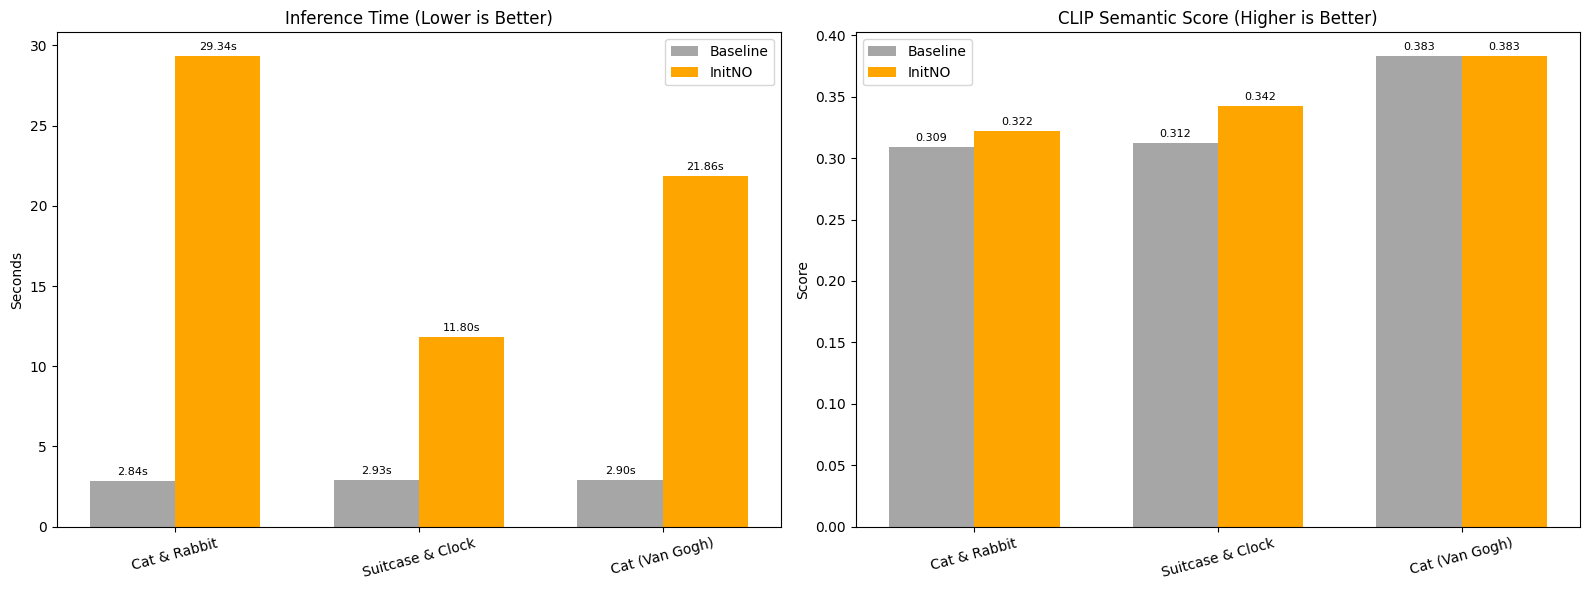

Prompt,Baseline,InitNO
Cat & Rabbit,,
Suitcase & Clock,,
Cat (Van Gogh),,


In [4]:
for i, item in enumerate(PROMPTS_DATA):
    base_path = f"{OUTPUT_DIR}/base_{i}.png"
    b_score = get_score(base_path, item["text"], clip_model, clip_processor)
    benchmark_results["baseline_clip"].append(b_score)
    
    initno_path = f"{OUTPUT_DIR}/initno_{i}_seed{SEED}.png"
    i_score = get_score(initno_path, item["text"], clip_model, clip_processor)
    benchmark_results["initno_clip"].append(i_score)
    
    print(f"  Scored {item['short']} | Base: {b_score:.4f} | InitNO: {i_score:.4f}")


x = np.arange(len(benchmark_results["labels"]))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

rects_time_base = ax1.bar(x - width/2, benchmark_results["baseline_times"], width, label='Baseline', color='gray', alpha=0.7)
rects_time_initno = ax1.bar(x + width/2, benchmark_results["initno_times"], width, label='InitNO', color='orange')
ax1.set_title('Inference Time (Lower is Better)')
ax1.set_ylabel('Seconds')
ax1.set_xticks(x)
ax1.set_xticklabels(benchmark_results["labels"], rotation=15)
ax1.legend()


rects_clip_base = ax2.bar(x - width/2, benchmark_results["baseline_clip"], width, label='Baseline', color='gray', alpha=0.7)
rects_clip_initno = ax2.bar(x + width/2, benchmark_results["initno_clip"], width, label='InitNO', color='orange')
ax2.set_title('CLIP Semantic Score (Higher is Better)')
ax2.set_ylabel('Score')
ax2.set_xticks(x)
ax2.set_xticklabels(benchmark_results["labels"], rotation=15)
ax2.legend()

def autolabel_bar(ax, rects, precision=3, suffix=''):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.{precision}f}{suffix}', xy=(rect.get_x() + rect.get_width()/2, height), 
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

autolabel_bar(ax1, rects_time_base, precision=2, suffix='s')
autolabel_bar(ax1, rects_time_initno, precision=2, suffix='s')
autolabel_bar(ax2, rects_clip_base, precision=3)
autolabel_bar(ax2, rects_clip_initno, precision=3)

plt.tight_layout()
plt.show() 

from IPython.display import display, HTML

html = f"<h3>Visual Comparison (Seed {SEED})</h3><table style='width:100%'><tr><th>Prompt</th><th>Baseline</th><th>InitNO</th></tr>"

for i, label in enumerate(benchmark_results["labels"]):
    base_img = f"{OUTPUT_DIR}/base_{i}.png"
    initno_img = f"{OUTPUT_DIR}/initno_{i}_seed{SEED}.png" 
    
    html += f"<tr><td>{label}</td><td><img src='{base_img}' width='250'></td><td><img src='{initno_img}' width='250'></td></tr>"
html += "</table>"
display(HTML(html)) 

In [7]:
!pip install imageio imageio-ffmpeg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 243.3 kB/s  0:02:00m0:00:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imageio]m1/2 [imageio]


Saving 50 intermediate steps to: notebook_step_by_step
Will plot steps [0, 5, 10, 20, 35, 49] inline.


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]
/home/aida/miniconda3/lib/python3.13/site-packages/diffusers/loaders/lora_pipeline.py:6931: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)
 70%|███████   | 7/10 [00:03<00:01,  1.79it/s]


  > Processed step 5
  > Processed step 10
  > Processed step 15
  > Processed step 20
  > Processed step 25
  > Processed step 30
  > Processed step 35
  > Processed step 40
  > Processed step 45
  > Processed step 49
  > Processed step 50


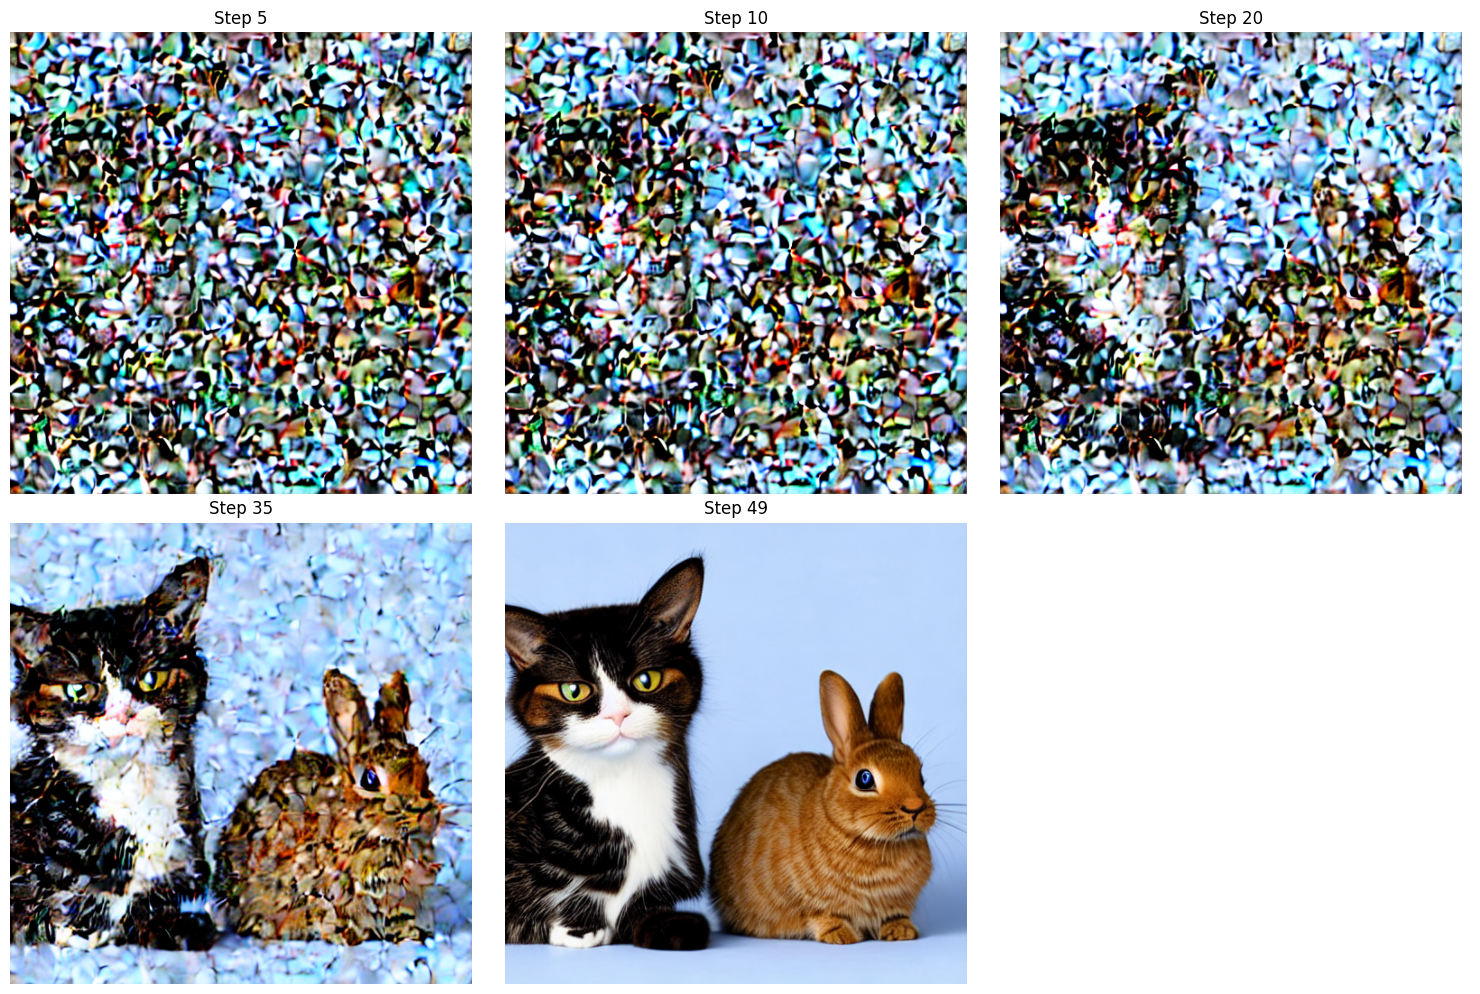

/tmp/ipykernel_434608/3439552649.py:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_files.append(imageio.imread(filename))


In [5]:
import functools
import imageio 
from PIL import Image
import matplotlib.pyplot as plt 

STEP_OUTPUT_DIR = "notebook_step_by_step"
os.makedirs(STEP_OUTPUT_DIR, exist_ok=True)
STEP_PROMPT = "a cat and a rabbit"
STEP_INDICES = [2, 5]
NUM_STEPS = 50

STEPS_TO_PLOT = [0, 5, 10, 20, 35, NUM_STEPS - 1] 
inline_images = [] 

print(f"Saving {NUM_STEPS} intermediate steps to: {STEP_OUTPUT_DIR}")
print(f"Will plot steps {STEPS_TO_PLOT} inline.")

def save_step_callback(step, timestep, latents, pipe, output_dir, vae_scaling_factor, steps_to_plot_list, image_list):

    latents_scaled = 1 / vae_scaling_factor * latents
    with torch.no_grad():
        image = pipe.vae.decode(latents_scaled).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")
    
    pil_image = Image.fromarray(image[0])
    
    pil_image.save(f"{output_dir}/step_{step:04d}.png")
    
    if step in steps_to_plot_list:
        image_list.append((step, pil_image))
    
    if step % 5 == 0 or step == NUM_STEPS - 1:
        print(f"  > Processed step {step}")

flush_memory()

pipe_initno = StableDiffusionInitNOPipeline.from_pretrained(
    MODEL_ID, torch_dtype=torch.float16, local_files_only=True
).to(DEVICE)
pipe_initno.set_progress_bar_config(disable=True)

vae_scaling_factor = pipe_initno.vae.config.scaling_factor
generator = torch.Generator(DEVICE).manual_seed(SEED)

callback_with_args = functools.partial(
    save_step_callback, 
    pipe=pipe_initno, 
    output_dir=STEP_OUTPUT_DIR, 
    vae_scaling_factor=vae_scaling_factor,
    steps_to_plot_list=STEPS_TO_PLOT, 
    image_list=inline_images        
)
images = pipe_initno(
    prompt=STEP_PROMPT,
    token_indices=STEP_INDICES,
    guidance_scale=7.5,
    num_inference_steps=NUM_STEPS,
    max_iter_to_alter=SAFE_ITERATIONS, 
    result_root=OUTPUT_DIR,
    generator=generator,
    seed=SEED,
    run_sd=False,
    callback=callback_with_args,
    callback_steps=1
).images

if images:
    images[0].save(f"{STEP_OUTPUT_DIR}/_FINAL_image.png")

del pipe_initno
flush_memory()

num_images_to_plot = len(inline_images)
if num_images_to_plot > 0:

    cols = 3
    rows = (num_images_to_plot + cols - 1) // cols 
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten() 

    for i, (step, img) in enumerate(inline_images):
        axes[i].imshow(img)
        axes[i].set_title(f"Step {step}")
        axes[i].axis("off")
    
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
        
    plt.tight_layout()
    plt.show()
else:
    print("err.")


try:
    image_files = []
    for i in range(NUM_STEPS):
        filename = f"{STEP_OUTPUT_DIR}/step_{i:04d}.png"
        if os.path.exists(filename):
            image_files.append(imageio.imread(filename))
        
    if image_files:
        imageio.mimsave(f"{OUTPUT_DIR}/generation_process.gif", image_files, fps=10)
    else:
        print("error.")
        
except ImportError:
    print("err.")
except Exception as e:
    print(f"Error creating GIF: {e}")